## 전처리한 데이터 가지고 오기

In [1]:
%pip install -q lightgbm scikit-learn optuna

Note: you may need to restart the kernel to use updated packages.


In [1]:
# ライブラリのインポート
import pandas as pd
import lightgbm as lgb
import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from lightgbm import early_stopping, log_evaluation

In [43]:
# データ読み込み
df = pd.read_csv('../data/combined_batches_domain_age.csv')

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103500 entries, 0 to 103499
Data columns (total 30 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   url                   103500 non-null  object 
 1   url_type              103500 non-null  int64  
 2   url_len               103500 non-null  int64  
 3   letters_count         103500 non-null  int64  
 4   digits_count          103500 non-null  int64  
 5   special_chars_count   103500 non-null  int64  
 6   shortened             103500 non-null  int64  
 7   is_domain_in_url      103500 non-null  int64  
 8   secure_http           103500 non-null  int64  
 9   redirect_count        103500 non-null  int64  
 10  duration_sec          103500 non-null  float64
 11  meta_count            103500 non-null  float64
 12  link_count            103500 non-null  float64
 13  title_count           103500 non-null  float64
 14  has_title             103500 non-null  bool   
 15  

特徴量とラベルに分割

In [45]:

df['digit_ratio'] = df['digits_count'] / (df['url_len'] + 1e-5)
df['meta_density'] = df['meta_count'] / (df['duration_sec'] + 1e-5)
df['performance_ratio'] = df['SpeedIndex'] / (df['duration_sec'] + 1e-5)
df = df.drop(columns=['error_reason'])
# 特徴量とラベルの分離
y = df['url_type']  # ← 例：0=benign, 1=phishing, 2=malwareなど

columns = ['url_type', 'url_len', 'letters_count', 'performance_score',
           'title_count', 'is_domain_in_url', 'batch_number', 'extracted_domain']
X = df.drop(columns=columns)
X = X.select_dtypes(include=['int64', 'float64', 'bool'])

学習・検証データに分割

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

LightGBMデータ形式に変換

In [47]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

### Optunaによるハイパーパラメータチューニング

In [ ]:
from sklearn.metrics import f1_score
import lightgbm as lgb
import optuna
from lightgbm import early_stopping, log_evaluation

def objective(trial):
    boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'goss'])

    param = {
        'objective': 'multiclass',
        'num_class': y.nunique(),
        'metric': 'multi_logloss',
        'boosting_type': boosting_type,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 5.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 5.0),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.0, 1.0),
        'max_bin': trial.suggest_int('max_bin', 128, 255),  # GPU互換範囲
        'verbosity': -1,
        'feature_pre_filter': False,
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0
    }

    # GOSS以外なら bagging を追加
    if boosting_type != 'goss':
        param.update({
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7)
        })

    num_boost_round = trial.suggest_int('num_boost_round', 100, 1000)

    train_dataset = lgb.Dataset(X_train, label=y_train)
    valid_dataset = lgb.Dataset(X_test, label=y_test)

    model = lgb.train(
        param,
        train_dataset,
        valid_sets=[valid_dataset],
        num_boost_round=num_boost_round,
        callbacks=[
            early_stopping(stopping_rounds=30),
            log_evaluation(period=50)
        ]
    )

    preds = model.predict(X_test)
    pred_labels = preds.argmax(axis=1)
    f1 = f1_score(y_test, pred_labels, average='macro')
    return f1


# Optunaの探索開始
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# 最良パラメータの出力
print("🔧 Best parameters found by Optuna:")
print(study.best_params)


In [11]:
print("🔧 Best parameters found by Optuna:")
print(study.best_params)

🔧 Best parameters found by Optuna:
{'boosting_type': 'gbdt', 'learning_rate': 0.14076351038446086, 'num_leaves': 142, 'max_depth': 13, 'min_data_in_leaf': 28, 'feature_fraction': 0.7446539717567593, 'lambda_l1': 0.41660865861247975, 'lambda_l2': 1.7251506906632443, 'min_gain_to_split': 8.210536993685791e-05, 'max_bin': 201, 'bagging_fraction': 0.9009619216154634, 'bagging_freq': 7, 'num_boost_round': 788}


ハイパーパラメータ設定とモデル学習

In [48]:
# Optunaのベストパラメータに固定設定を追加
# best_params = study.best_params.copy()  # ← 上書き防止のため copy()

best_params = {'learning_rate': 0.25198045073380176, 'num_leaves': 110, 'max_depth': 15, 'min_data_in_leaf': 86, 'feature_fraction': 0.7139552624284528, 'bagging_fraction': 0.9483688703020394, 'bagging_freq': 1}
# GOSSの場合は bagging 系のパラメータを削除（LightGBMがエラーを出すため）
if best_params.get("boosting_type") == "goss":
    best_params.pop("bagging_fraction", None)
    best_params.pop("bagging_freq", None)

# 固定値を追加
best_params.update({
    'objective': 'multiclass',
    'num_class': y.nunique(),
    'metric': 'multi_logloss',
    'verbosity': -1,
    'feature_pre_filter': False,
    'device': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0
})

# Dataset 再作成（エラー回避＆安定性）
train_dataset = lgb.Dataset(X_train, label=y_train)
valid_dataset = lgb.Dataset(X_test, label=y_test)

# モデル再学習（num_boost_round もチューニング結果から）
model = lgb.train(
    best_params,
    train_dataset,
    valid_sets=[train_dataset, valid_dataset],
    num_boost_round=best_params.get('num_boost_round', 100),
    callbacks=[
        early_stopping(stopping_rounds=30),
        log_evaluation(period=10)
    ]
)


Training until validation scores don't improve for 30 rounds
[10]	training's multi_logloss: 0.405926	valid_1's multi_logloss: 0.430952
[20]	training's multi_logloss: 0.296184	valid_1's multi_logloss: 0.337583
[30]	training's multi_logloss: 0.247977	valid_1's multi_logloss: 0.306531
[40]	training's multi_logloss: 0.215267	valid_1's multi_logloss: 0.288345
[50]	training's multi_logloss: 0.190355	valid_1's multi_logloss: 0.275661
[60]	training's multi_logloss: 0.169508	valid_1's multi_logloss: 0.267657
[70]	training's multi_logloss: 0.152303	valid_1's multi_logloss: 0.261552
[80]	training's multi_logloss: 0.137469	valid_1's multi_logloss: 0.256899
[90]	training's multi_logloss: 0.124427	valid_1's multi_logloss: 0.25361
[100]	training's multi_logloss: 0.112843	valid_1's multi_logloss: 0.249475
Did not meet early stopping. Best iteration is:
[100]	training's multi_logloss: 0.112843	valid_1's multi_logloss: 0.249475


予測と評価

In [50]:
y_pred_proba = model.predict(X_test)
y_pred = y_pred_proba.argmax(axis=1)
print("📊 Classification Report")
print(classification_report(y_test, y_pred))

print("🧩 Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("\n🧩 전체 클래스 간 오분류 분석")

# 클래스 목록 가져오기 (0,1,2 외의 클래스도 대응 가능)
classes = sorted(set(y_test) | set(y_pred))

# y_test와 y_pred가 시리즈일 경우를 고려하여 numpy 배열로 변환
y_true = y_test.values if isinstance(y_test, pd.Series) else y_test
y_pred_np = y_pred if not isinstance(y_pred, pd.Series) else y_pred.values

# 모든 클래스 쌍 (i ≠ j)에 대해 루프
for i in classes:
    for j in classes:
        if i == j:
            continue  # 정답인 경우는 건너뜀 (오분류만 분석)

        # i → j로 오분류된 인스턴스를 찾음
        misclassified_mask = (y_true == i) & (y_pred_np == j)

        if misclassified_mask.sum() > 0:
            print(f"\n🔍 클래스 {i} → 클래스 {j} 로 오분류된 인스턴스 수: {misclassified_mask.sum()}")
            print(X_test[misclassified_mask].describe())
        else:
            print(f"\n✅ 클래스 {i} → 클래스 {j} 오분류 없음")

📊 Classification Report
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      5246
           1       0.95      0.98      0.96      7883
           2       0.87      0.89      0.88      7571

    accuracy                           0.90     20700
   macro avg       0.90      0.89      0.89     20700
weighted avg       0.90      0.90      0.90     20700

🧩 Confusion Matrix
[[4196  178  872]
 [  53 7733   97]
 [ 565  265 6741]]

🧩 전체 클래스 간 오분류 분석

🔍 클래스 0 → 클래스 1 로 오분류된 인스턴스 수: 178
       digits_count  special_chars_count  shortened  secure_http  \
count    178.000000           178.000000      178.0        178.0   
mean       2.808989            11.202247        0.0          0.0   
std        4.350145             6.021017        0.0          0.0   
min        0.000000             5.000000        0.0          0.0   
25%        0.000000             7.000000        0.0          0.0   
50%        0.000000            10.000000        0.0       

重要な特徴量を可視化

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

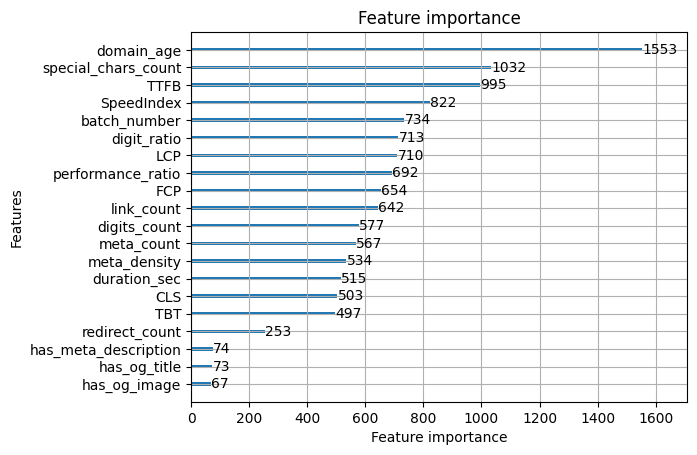

In [9]:
lgb.plot_importance(model, max_num_features=20)

In [28]:
import lightgbm as lgb
import pandas as pd

# Booster 形式のモデル（model）が前提
importances = model.feature_importance(importance_type='gain')
feature_names = model.feature_name()

# 特徴量と重要度をDataFrame化して小さい順に並べる
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=True)

# 下位5%の特徴量を削除候補として抽出
low_importance_cols = importance_df.head(int(len(importance_df) * 0.05))['feature'].tolist()

# 結果の確認
print("🔍 削除候補の特徴量（重要度下位5%）:")
print(low_importance_cols)

# 全特徴量の重要度（上位も含む）を見たい場合
display(importance_df)


🔍 削除候補の特徴量（重要度下位5%）:
['shortened']


,feature,importance
2,shortened,0.000000
8,has_title,437.105592
12,has_link_stylesheet,1319.143532
10,has_og_image,1340.193354
11,has_og_title,1679.753925
9,has_meta_description,2060.568718
4,redirect_count,6617.667374
5,duration_sec,7872.244268
3,secure_http,9122.029550
21,meta_density,9502.630496
